# Add attributes to GNSS data

Using the pandas series, i add attributes to the data, e.g. velocity, for analysis

Using this i take a first look at speed up events

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import linalg as LA
from functools import reduce
import os
import sys
import time
import datetime 
import pandas as pd
import geopandas as gpd

from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

sys.path.append(os.path.abspath('/Users/home/whitefar/DATA/code/'))
os.chdir("/Users/home/whitefar/DATA/TASMAN/ABSOLUTE/")

In [2]:
#with only the site_units that have data over the time period
site_units = [['tal1', 'arc2'], ['tal2', 'arc1'], ['tac2', 'arc5'], ['tac3', 'arc4'], ['tar2', 'arc6']] #these are the ones with data

dfs = {}  #dataframes

for site, unit in site_units:
    dfs[site+unit] = pd.read_csv(f"/Volumes/arc_02/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/{site}{unit}_may1-18_2016.csv",index_col=0)

In [3]:
dfs.keys()

dict_keys(['tal1arc2', 'tal2arc1', 'tac2arc5', 'tac3arc4', 'tar2arc6'])

## make geodataframe in NZ transverse mercator

In [4]:
gdfs = {}

for df in dfs:
    geometry = [Point(xy) for xy in zip(dfs[df].Longitude, dfs[df].Latitude)]
    gdfs[df] = GeoDataFrame(dfs[df], crs={'init': 'epsg:4326'}, geometry=geometry)  
    
    gdfs[df] = gdfs[df].rename(columns={'geometry': 'Points'}).set_geometry('Points').to_crs(epsg=2193)
   

## add distance, velocity

In [47]:
for gdf in gdfs:
    gdfs[gdf] = gdfs[gdf].to_crs({'init': 'epsg:2193'} )
    
    distance_from_prev = [Point.distance(gdfs[gdf].Points[i]) for i,Point in enumerate(gdfs[gdf].Points[1:])] #note the 1:, equivalent to i+1
    distance_from_prev.insert(0,0)   
    gdfs[gdf]["distance"] =pd.Series( distance_from_prev)
    
    gdfs[gdf]["cumulative_distance"] = pd.Series.cumsum(gdfs[gdf]["distance"])
    
    gdfs[gdf]["datetime"] = pd.Series([datetime.datetime.fromtimestamp(timestamp) for timestamp in gdfs[gdf].Timestamp])
    
    gdfs[gdf]["dt"] = gdfs[gdf]["Timestamp"].diff()
    
    gdfs[gdf]["velocity"] = pd.Series([d/gdfs[gdf].dt[i] for i,d in enumerate(gdfs[gdf]["distance"])])
    
    gdfs[gdf]["velocity"] = gdfs[gdf]["velocity"].multiply(60*60*24*365.25) #convert to m/a
    
    dfs[df].to_csv(f"/Volumes/arc_02/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/GNSS_dataframe/{df}_moreattributes.csv")

In [48]:
gdfs['tal1arc2']["cumulative_distance"].to_numpy().max()

396.8055302000626

In [49]:
gdfs['tal1arc2']["velocity"].to_numpy().max()

nan

In [14]:
# crs = {'init': 'epsg:4326'} 
# #make a geodataseries
# for df in dfs:
        
#     dfs[df] = GeoDataFrame(dfs[df], crs=crs, geometry="Points")  

In [15]:
# crs = {'init': 'epsg:4326'} 

# #make a geodataseries
# for df in dfs:
    
#     dfs[df] = GeoDataFrame(dfs[df], crs=crs, geometry=geometry)  
    
#     dfs[df].to_file(f"/Volumes/arc_02/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/{df}_moreattributes.shp")
     
#     dfs[df] = dfs[df].rename(columns={'geometry': 'Points'})

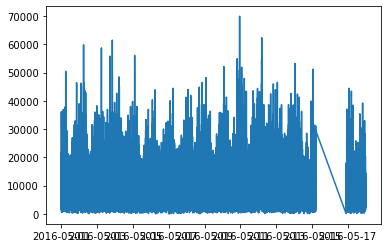

In [50]:
plt.plot(gdfs['tal1arc2'].datetime,gdfs['tal1arc2'].velocity)

In [51]:
gdfs['tal1arc2'].columns

Index(['Timestamp', 'site', 'unit', 'Year', 'DOY', 'Seconds', 'Latitude',
       'Longitude', 'Height', 'SigN', 'SigE', 'SigH', 'RMS', 'DDiff', 'Atm',
       '+-', 'Fract', 'DOY.1', 'Epoch', '#BF', 'NotF', 'Points', 'distance',
       'cumulative_distance', 'datetime', 'dt', 'velocity'],
      dtype='object')

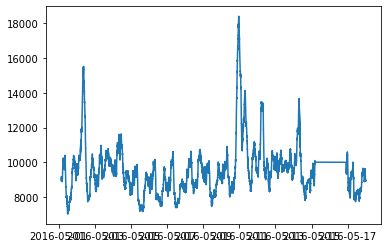

In [52]:
plt.plot(gdfs['tal1arc2'].datetime,gdfs['tal1arc2'].velocity.rolling(window=400).mean())

In [53]:
peak3 = np.argmax(gdfs['tal1arc2'].velocity.rolling(window=300).mean().to_numpy()[300:])
peak2 = np.argmax(gdfs['tal1arc2'].velocity.rolling(window=200).mean().to_numpy()[200:])
peak1 = np.argmax(gdfs['tal1arc2'].velocity.rolling(window=100).mean().to_numpy()[100:])
peak0 = np.argmax(gdfs['tal1arc2'].velocity.rolling(window=10).mean().to_numpy()[10:])
print(peak0,peak1,peak2,peak3)
print(gdfs['tal1arc2'].datetime[peak1])

28668 28612 28250 28233
2016-05-10 22:30:30


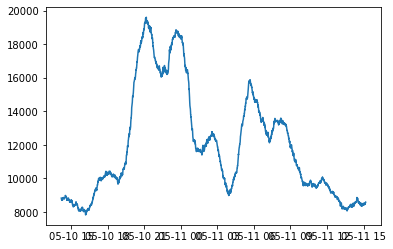

In [54]:
f = peak1-1000
t = peak1 + 2000
plt.plot(gdfs['tal1arc2'].datetime[f:t],gdfs['tal1arc2'].velocity.rolling(window=200).mean()[f:t])

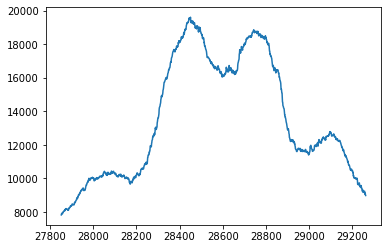

In [55]:
f = peak1-760
t = peak1 + 650
plt.plot(gdfs['tal1arc2'].velocity.rolling(window=200).mean()[f:t])

# Find speedup events

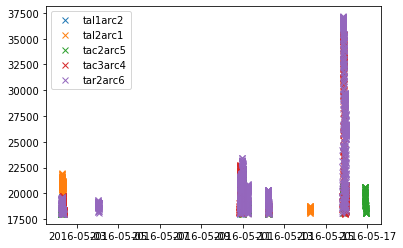

In [68]:
for gdf in gdfs.keys():
    event_indicies = np.argwhere(gdfs[gdf].velocity.rolling(window=200).mean() > 18000).flatten()
    plt.plot(gdfs[gdf].datetime[event_indicies],gdfs[gdf].velocity.rolling(window=200).mean()[event_indicies],'x')
plt.legend(gdfs.keys())
plt.show()

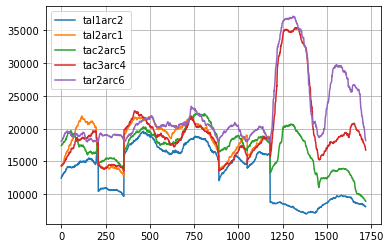

In [69]:
for gdf in gdfs.keys():
    plt.plot(np.arange(len(event_indicies)),gdfs[gdf].velocity.rolling(window=200).mean()[event_indicies])
plt.grid()
plt.legend(gdfs.keys())
plt.show()

In [70]:
event_dates = gdfs['tac3arc4'].datetime[event_indicies].dt.date.drop_duplicates()

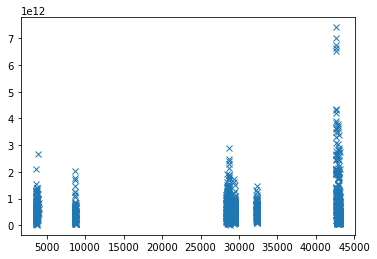

In [71]:
plt.plot(gdfs['tar2arc6'].velocity[event_indicies]*60*60*24*365.25,'x')